## Google's Mask RCNN Model (TensorFlow)

In [ ]:
!pip install tensorflow==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 22 kB/s 
     |████████████████████████████████| 503 kB 37.5 MB/s 
     |████████████████████████████████| 50 kB 5.1 MB/s 
     |████████████████████████████████| 3.8 MB 21.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=9a4fd7bae27d9cf365a83302930c3a89a226289d1cb3d73089f06a35eb625c74
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

In [ ]:
import tensorflow
tensorflow.__version__

'1.15.0'

### Scope:

Using pretrained model on COCO dataset, we'd like to use the model to identify the car objects inside any passed image.

In [ ]:
import tensorflow as tf

In [ ]:
!git clone https://github.com/tensorflow/tpu

fatal: destination path 'tpu' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.insert(0,'tpu/models/official')
sys.path.insert(0,'tpu/models/official/mask_rcnn')

In [ ]:
from IPython import display
from PIL import Image

import numpy as np
import coco_metric
from mask_rcnn.object_detection import visualization_utils

In [ ]:
OUTPUT_LABEL = {
    3:'car',
    8:'truck',
    6:'bus'
}     
category_index = {k: {'id':k, 'name':OUTPUT_LABEL[k]} for k in OUTPUT_LABEL} 

In [ ]:
category_index

{0: {'id': 0, 'name': 'car'},
 1: {'id': 1, 'name': 'truck'},
 2: {'id': 2, 'name': 'bus'}}

In [ ]:
!wget https://images.squarespace-cdn.com/content/v1/593196625016e16bb40f6f78/1647575581831-0H7JY2HVFVM5BPFNYB9B/DSCF9390.jpg -O traffic_new.jpg

--2022-10-22 13:17:07--  https://images.squarespace-cdn.com/content/v1/593196625016e16bb40f6f78/1647575581831-0H7JY2HVFVM5BPFNYB9B/DSCF9390.jpg
Resolving images.squarespace-cdn.com (images.squarespace-cdn.com)... 151.101.0.238, 151.101.64.238, 151.101.128.238, ...
Connecting to images.squarespace-cdn.com (images.squarespace-cdn.com)|151.101.0.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 714755 (698K) [image/jpeg]
Saving to: ‘traffic_new.jpg’

traffic_new.jpg     100%[===================>] 698.00K  --.-KB/s    in 0.04s   

2022-10-22 13:17:07 (15.3 MB/s) - ‘traffic_new.jpg’ saved [714755/714755]



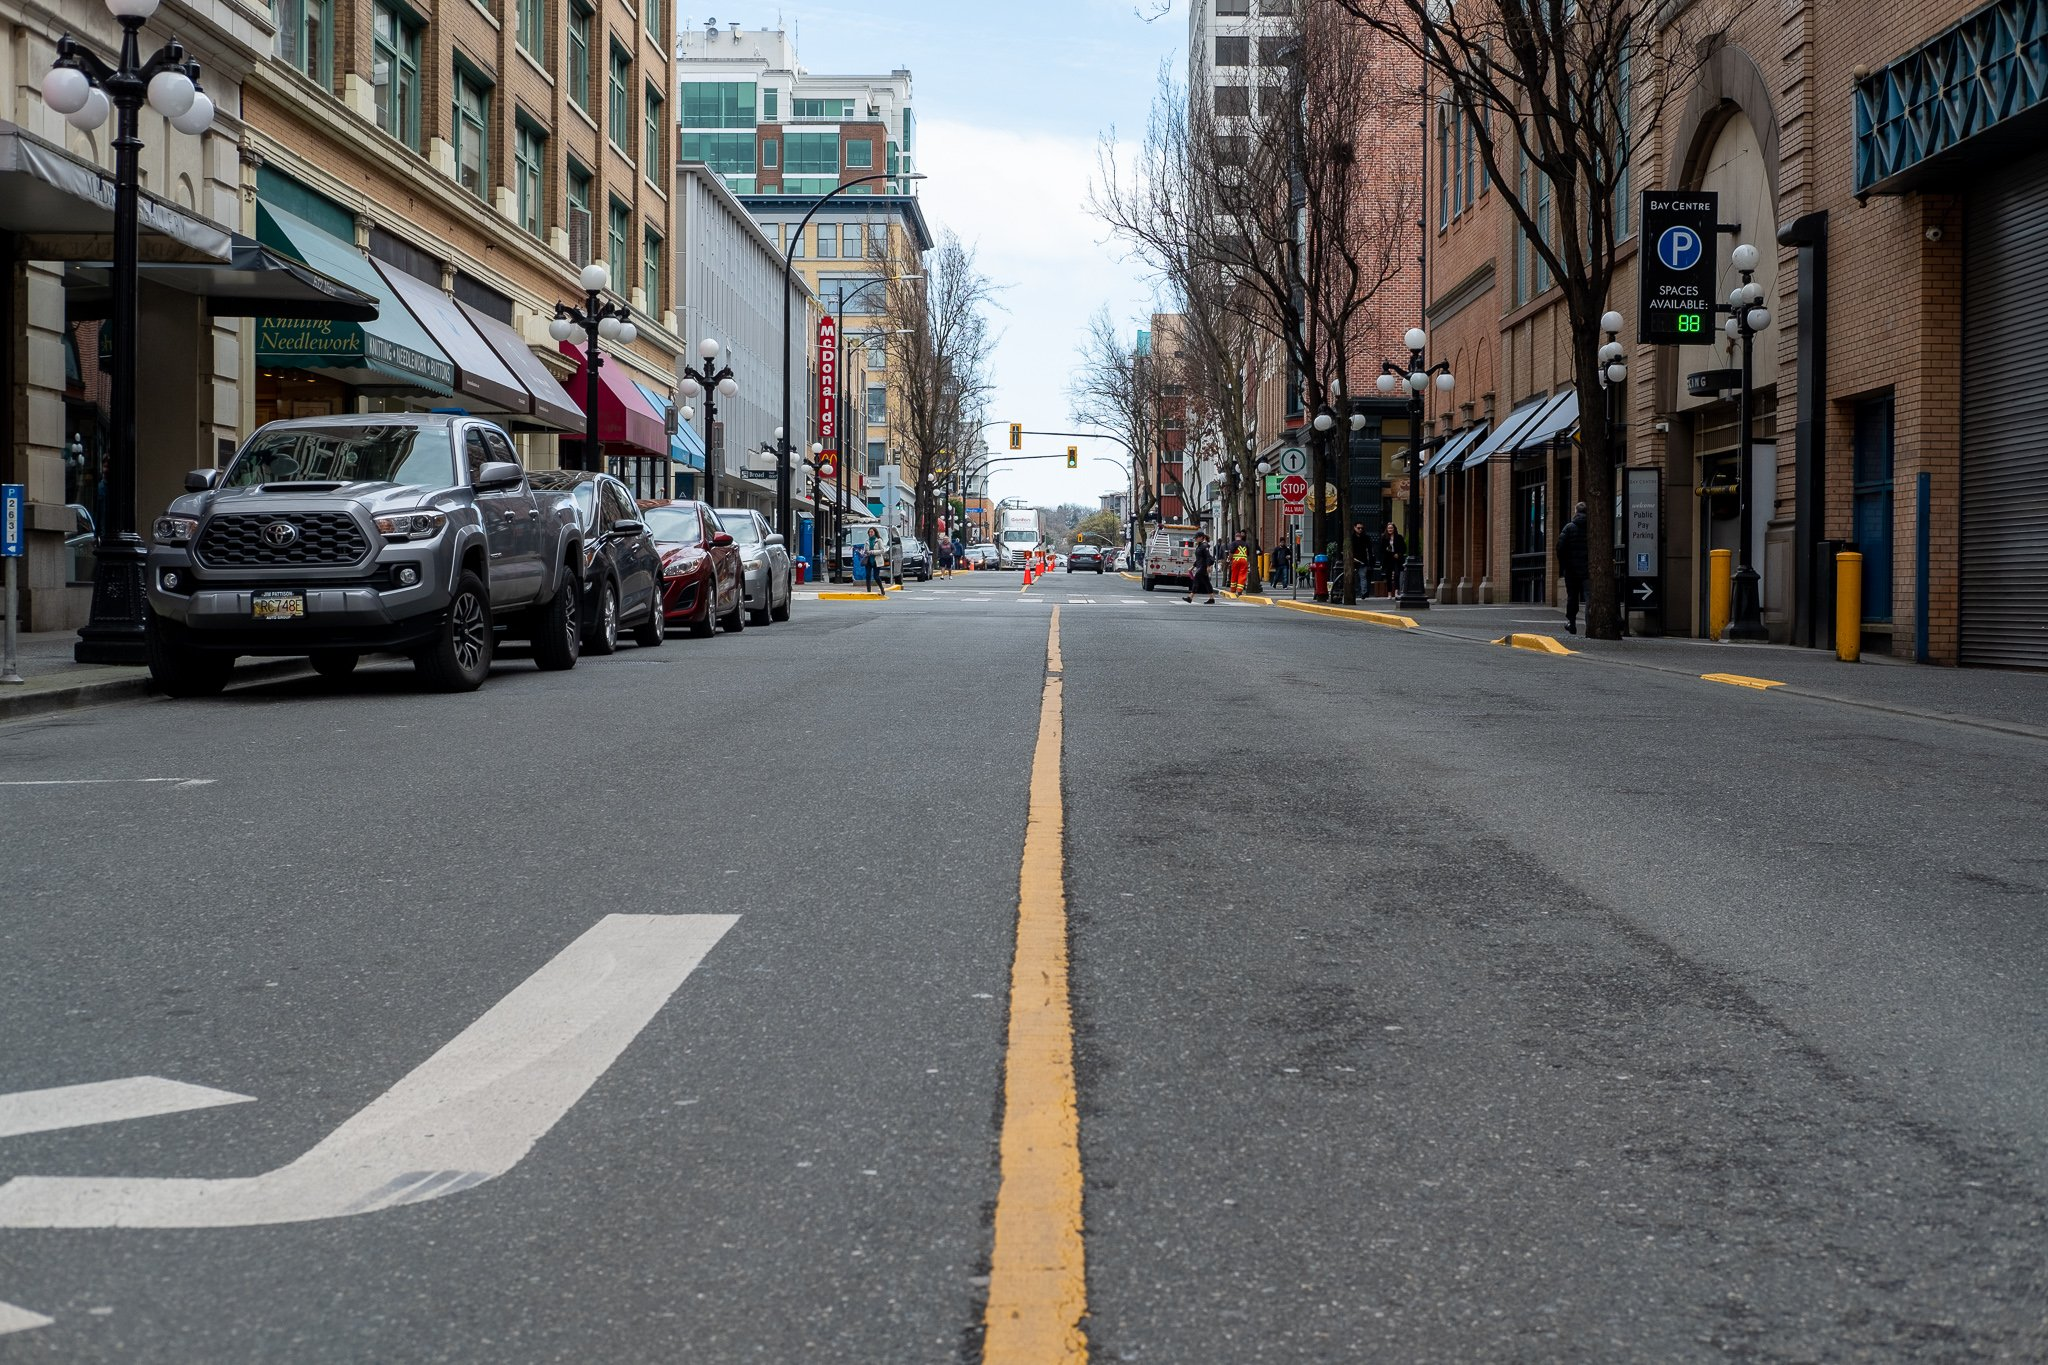

In [ ]:
from PIL import Image

image_path = 'traffic_new.jpg'

with open(image_path,'rb') as f:
  np_image_string = np.array([f.read()])

image = Image.open(image_path)

width, height = image.size

np_image = np.array(image.getdata()).reshape(height,width,3).astype(np.uint8)

display.display(
    display.Image(image_path, width = 320)
)

In [ ]:
width

2048

In [ ]:
use_tpu = True

import os
import pprint
import tensorflow as tf

TPU_ADDRESS = 'grpc://'+ os.environ['COLAB_TPU_ADDR']

session = tf.Session(TPU_ADDRESS, graph=tf.Graph())

print(session.list_devices())
#session.tf.Session()

[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 6343541609636783441), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 15623883966867967867), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4251390327304167256), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 14967791311329641033), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5904360571088546731), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 15056186761638808986), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 12077445718514873245), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 14390002685191682132), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 17168943985270276949), _DeviceAttributes(/job:tpu_worker/replica:0/

In [ ]:
file_location = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'

_ = tf.saved_model.loader.load(session, ['serve'],file_location)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


In [ ]:
session

In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0','DetectionBoxes:0','DetectionClasses:0','DetectionScores:0','DetectionMasks:0','ImageInfo:0'], feed_dict={'Placeholder:0':np_image_string}
)

In [ ]:
num_detections.astype(np.int32)

array([77], dtype=int32)

In [ ]:
num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))

detection_boxes = np.squeeze(detection_boxes * image_info[0,2],axis = (0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis = (0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin,xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax-ymin], axis = -1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks,processed_boxes, height, width)


In [ ]:
print(detection_classes)

[ 3  3  1  3  3  3  1  1  1 10  3 10  8  3 13  1  1  3  1  3  8  1  3  3
  3  3 10  3  1  1  3  1  1  1  1  3  3  1  3  1 10  3  1  3  1  1  1  1
  1  1  3  1 10  8  3  6  1  1  1  1  3  1 10  1  1 10  1 10  3  1  3  8
  3  1  3  1  1]


In [ ]:
image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks = segmentations,
    use_normalized_coordinates = False,
    max_boxes_to_draw = 50,
    min_score_thresh = 0.2
)


In [ ]:
Image.fromarray(image_with_detections.astype(np.uint8)).save('traffic_new_withLabels.jpg')

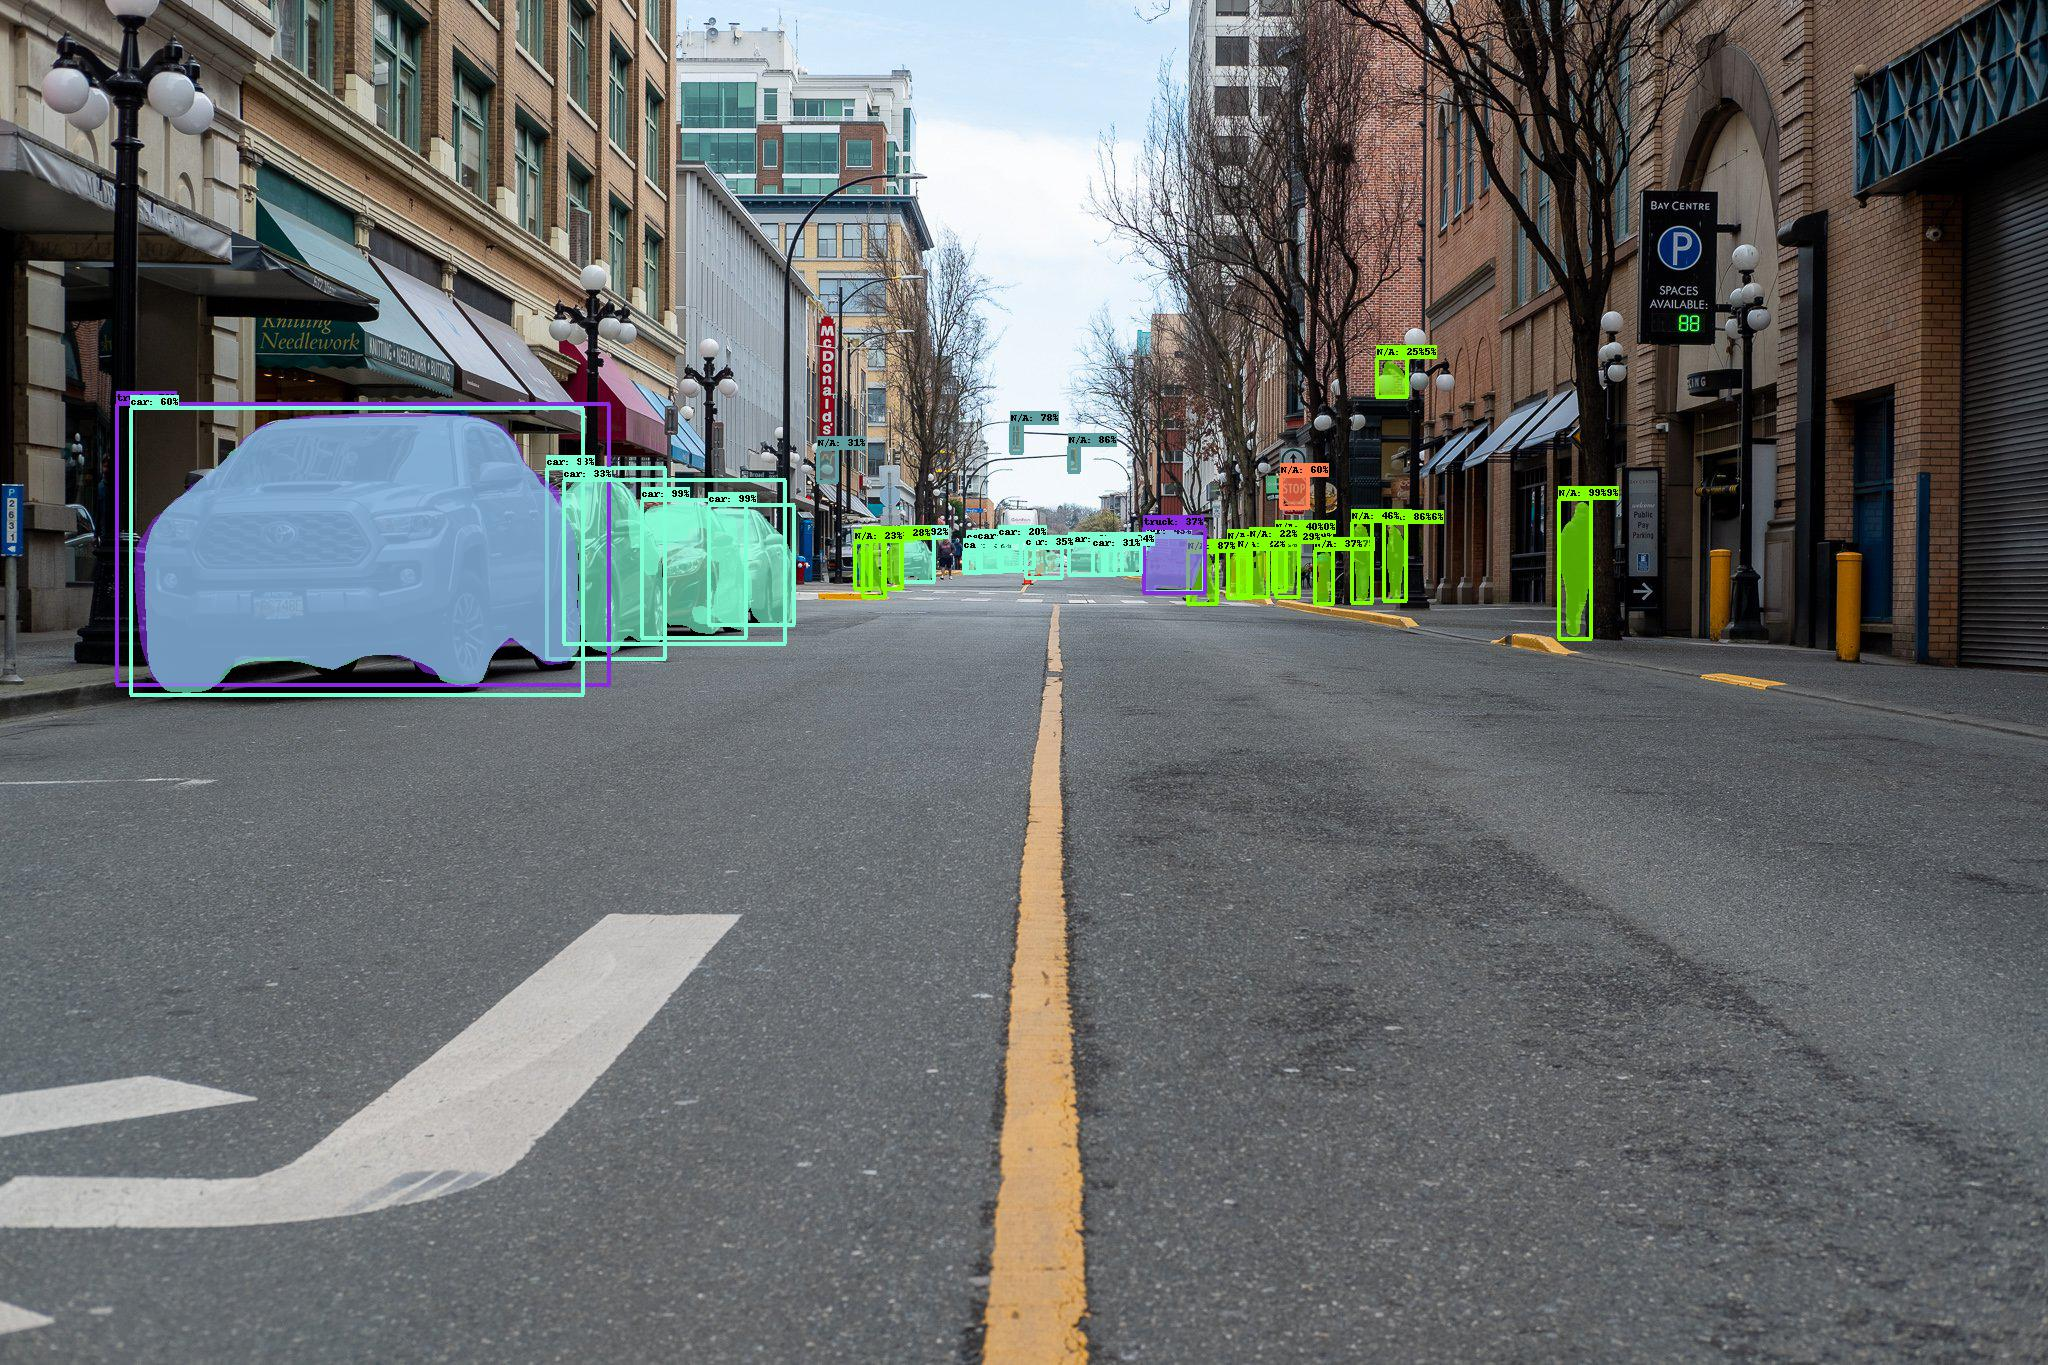

In [ ]:
display.display(
    display.Image('traffic_new_withLabels.jpg', width = 4096)
)

# To do: 
As a next step: 
1. Create a function that receives the Image as an input
2. Calculates the image dimensions, and passes the image to the TPU loaded model
3. Extract `num_detections`, `detection_boxes`, `detection_classes`, `detection_scores`, `detection_masks`, `image_info` from the model
4. Return an image with overlayed labels, masks and bounding boxes
5. OR return objects with following structure:
```
{[
  "class": "car",
  "probability": 45%,
  "bounding_boxes": [(xmin,ymin, xmax,ymax}]
], ...
}
```

6. Load a traffic camera data
7. Split the video into frames
8. Run the created function (above-mentioned) on all frames
EITHER: 
  9. recreate images with overlay annotations
  10. append all images into a video

OR:
  9. Get the time of video from video attributes
  10. Calculate the timestamp of the frame you have extracted from step 7
  11. Count the number of cars within that frame and store it in a dataframe
 